# 08 Convolutional neural network

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import PIL.Image as Image

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
print(hub.__version__)
print(tf.__version__)

0.4.0
1.12.0


In [3]:
# Some global variables
img_basepath = '/data/ml_course/04_Applied_Machine_Learning_2/11_Course_project/Swissroads_imgs/'
npixels = 224
nfeatures = 1280
nclasses = 6
nbatch = 32
nepochs = 50

In [4]:
# Load data
def load_data(img_basepath, set_type):
    nimages = len(glob.glob(os.path.join(img_basepath+set_type+'/*', '*.png')))
    names = ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']
    X = np.empty((nimages, npixels, npixels, 3), dtype=np.float32)
    y = np.empty(nimages, dtype=np.float32)
    img_count = 0
    for i, name in enumerate(names):
        img_file_list = glob.glob(os.path.join(img_basepath+set_type+'/'+name, '*.png'))
        for img_file in img_file_list:
            img = Image.open(img_file)
            img = img.resize((npixels, npixels))
            X[img_count, :, :, :] = np.array(img)/255
            y[img_count] = i
            img_count += 1
    return X, y

In [5]:
X_te, y_te = load_data(img_basepath, 'test')
X_va, y_va = load_data(img_basepath, 'valid')
X_tr, y_tr = load_data(img_basepath, 'train')
print(X_te.shape, y_te.shape)
print(X_va.shape, y_va.shape)
print(X_tr.shape, y_tr.shape)

(50, 224, 224, 3) (50,)
(139, 224, 224, 3) (139,)
(280, 224, 224, 3) (280,)


In [6]:
# Create graph
img_graph = tf.Graph()

with img_graph.as_default():
    # Download module
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'
    feature_extractor = hub.Module(module_url, trainable=True)

    # Create input placeholder
    X = tf.placeholder(dtype=tf.float32, shape=[None, npixels, npixels, 3])
    
    # Output placeholder
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # A node with the features
    imgs_features = feature_extractor(X)
    
    # Output layer
    logits = tf.layers.dense(
        imgs_features, nclasses, # One output unit per category
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [7]:
# Validation accuracy
valid_acc_values = []
train_acc_values = []
with tf.Session(graph=img_graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Train several epochs
    for epoch in range(nepochs):
        # training with all data at once
        # Run training and evaluate accuracy
        _, acc_value = sess.run([train_op, accuracy], feed_dict={
            X: X_tr,
            y: y_tr,
            lr: 0.00001 # Learning rate
        })
        train_acc_values.append(acc_value)
        
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_va,
            y: y_va,
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f}'.format(
            epoch+1, valid_acc, acc_value))
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te
    })
    print('Test accuracy: {:.3f}'.format(test_acc))

Epoch 1 - valid: 0.223 train: 0.164
Epoch 2 - valid: 0.302 train: 0.239
Epoch 3 - valid: 0.374 train: 0.300
Epoch 4 - valid: 0.439 train: 0.379
Epoch 5 - valid: 0.547 train: 0.493
Epoch 6 - valid: 0.604 train: 0.579
Epoch 7 - valid: 0.662 train: 0.632
Epoch 8 - valid: 0.698 train: 0.664
Epoch 9 - valid: 0.698 train: 0.668
Epoch 10 - valid: 0.719 train: 0.682
Epoch 11 - valid: 0.748 train: 0.736
Epoch 12 - valid: 0.755 train: 0.754
Epoch 13 - valid: 0.770 train: 0.782
Epoch 14 - valid: 0.791 train: 0.793
Epoch 15 - valid: 0.806 train: 0.804
Epoch 16 - valid: 0.813 train: 0.825
Epoch 17 - valid: 0.813 train: 0.836
Epoch 18 - valid: 0.820 train: 0.846
Epoch 19 - valid: 0.813 train: 0.868
Epoch 20 - valid: 0.813 train: 0.871
Epoch 21 - valid: 0.813 train: 0.886
Epoch 22 - valid: 0.813 train: 0.893
Epoch 23 - valid: 0.820 train: 0.900
Epoch 24 - valid: 0.820 train: 0.900
Epoch 25 - valid: 0.820 train: 0.907
Epoch 26 - valid: 0.835 train: 0.907
Epoch 27 - valid: 0.835 train: 0.918
Epoch 28 -

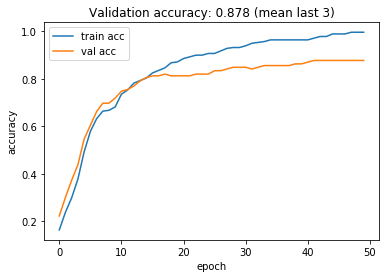

In [8]:
# Plot accuracy values
plt.plot(train_acc_values, label='train acc')
plt.plot(valid_acc_values, label='val acc')
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Store results

In [9]:
df_acc = pd.DataFrame(
    {'model': ['cnn'], 'test_accuracy': [100.*test_acc]})
df_acc.to_csv('acc_cnn.csv', index=False)

A reasonably good accuracy can be reached with a very small learning rate. However, there is not enough data to reach accuracies well above 90%